# Experiments Pertaining to Batch Size/ Learning Rate

#### Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import random
from pathlib import Path
from collections import OrderedDict
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
#import missingno as mso
#import pandas_profiling as pdp

import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

from torchvision import models
import torchvision.transforms as T
#from torchvision.utils import make_grid
#from efficientnet_pytorch import EfficientNet
#import torchsummary
# local files
from plotting import show_batch, plot_learning_curves
from modeling import CheXModel

C:\Users\Rygu\Anaconda3\envs\mldl\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


#### Globals

In [2]:
USE_CUDA = True
ON_AWS = True
NUM_WORKERS = 4 if ON_AWS else 0 
DEVICE = torch.device('cuda' if torch.cuda.is_available() and USE_CUDA else 'cpu')

In [3]:
SEED = 404
def seed_everything(seed=SEED, env=None):
    random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [4]:
PATH_DATA = Path('data/')
chxpath = PATH_DATA/'CheXpert-v1.0-small/'
path_train = chxpath/'train'
path_valid = chxpath/'valid'

In [9]:
TARGET_LABELS = ['No_Finding', 'Enlarged_Cardiomediastinum', 'Cardiomegaly',
       'Lung_Opacity', 'Lung_Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural_Effusion', 'Pleural_Other',
       'Fracture', 'Support_Devices']

## Data

In [5]:
df_train = pd.read_csv(chxpath/'train.csv')
df_valid = pd.read_csv(chxpath/'valid.csv')

In [51]:
def label_smooth(df, method='uones', smooth_bounds=None):
    df_sub = df.copy()
    if smooth_bounds is None:
        eps = 1e-5
        if method == 'uones':
            smooth_bounds = (0.55, 0.85+eps)
        elif method=='uzeros':
            smooth_bounds = (0, 0.30+eps)
        else:
            smooth_bounds = (0, 0.85+eps)
    
    if method in ['uones','uzeros']:
        smooth_distrb = np.random.uniform(*smooth_bounds,df_sub[TARGET_LABELS].shape)
        df_sub.loc[:,TARGET_LABELS] = np.where(df_sub[TARGET_LABELS]==-1, smooth_distrb, df_sub[TARGET_LABELS])
        
    return df_sub

def proc_df(df, method='uones', smooth=True, nafill_val=0, ufill_val=1, **kwargs):
    """
    Preprocess dataframe for model consumption
    
    Args:
        df (pandas.DataFrame): dataframe containing img paths, metadata, and labels.
        method (str), ('uzeros','uones','constant'): method for replacing uncertainty labels (default: 'uones')
        smooth (bool): use Label Smoothing Regression (LSR) only applies when `method`=('uzeros','uones') (default: True) 
        nafill_val (int,float): value used to fill nan values (default: 0)
        ufill_val (int,float): value used to fill -1 (uncertainty) labels
    
    kwargs:
        smooth_bounds (tuple(float,float)): replace -1 labels uniform random values between the given bounds
        (default: `method`='uzeros': (0,0.3001), `method`='uones': (0.55,0.8501) when `Smooth`=True, 
                
    Returns:
        processed_df: pandas.Dataframe
    """
    
    is_val = df['Path'].str.contains('valid').all()
    df_sub = df.rename(lambda x: x.replace(' ','_'), axis=1).drop(columns=['Sex','Age','Frontal/Lateral','AP/PA'])
    
    if is_val:
        return df_sub # val set has no nans, no -1s
    
    df_targets = df_sub[TARGET_LABELS]
    
    if isinstance(nafill_val,tuple):
        nan_smooth_distrb = np.random.uniform(*nafill_val, df_targets.shape)
        df_sub.loc[:,TARGET_LABELS] = np.where(df_targets.isna(), nan_smooth_distrb, df_targets)
    else:
        df_sub = df_sub.fillna(nafill_val)
    
    if smooth:
        df_sub = label_smooth(df_sub, method, kwargs.get('smooth_bounds'))
    elif method == 'constant':
        df_sub = df_sub.replace(-1,ufill_val)
    elif method in ['uzeros','uones'] and ufill_val not in [0.0,1.0]:
        print(f'WARNING: Overwritting `ufill_val` to match method "{method}"')
        ufill_val = 1.0 if method=='uones' else 0.0
        df_sub = df_sub.replace(-1,ufill_val)
    
    df_sub.loc[:,TARGET_LABELS] = df_sub.loc[:,TARGET_LABELS].astype(float)
    
    return df_sub

## Image Augmentations

In [157]:
FRONTAL_TEMPLATE1c = cv2.imread('templates/fnt_ext_template244.jpg', 0)
LATERAL_TEMPLATE1c = cv2.imread('templates/lat_ext_template244.jpg', 0)

def template_match(img, template, tm_method=cv2.TM_CCOEFF_NORMED, init_resize=(256,256)):
    h,w = template.shape
    if img.ndim > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img1c256 = cv2.resize(img, init_resize, interpolation=cv2.INTER_LINEAR)

    res = cv2.matchTemplate(img1c256, template, tm_method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    top_left = max_loc if tm_method not in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED] else min_loc
    bottom_right = (top_left[0] + w, top_left[1]+h)
    (x,y),(x1,y1) = top_left, bottom_right
    
    return cv2.cvtColor(img1c256[y:y1, x:x1], cv2.COLOR_GRAY2BGR)

In [158]:
class TemplateCrop(A.ImageOnlyTransform):
    """Match image to template of either a lateral or frontal view, resizing and cropping in the process.
    Args:
        tm_method (int): Template matching method
    Targets:
        image
    Image types:
        uint8, float32
    """

    def __init__(self, tm_method=cv2.TM_CCOEFF_NORMED, init_resize=(256,256), always_apply=False, p=1.0):
        super(TemplateCrop, self).__init__(always_apply, p)
        self.tm_method = tm_method
        self.init_resize = init_resize

    def apply(self, image, **params):
        template = LATERAL_TEMPLATE1c if params.get('is_lateral') else FRONTAL_TEMPLATE1c
        return template_match(image, template, self.tm_method, self.init_resize)

    def get_transform_init_args_names(self):
        return ("tm_method","init_resize")

In [452]:
def advprop(image,**kwargs):
    return image*2.0-1.0
def get_transforms(varient='train', tfms_lib='albu', imgsize=(244,244)):
    if tfms_lib == 'albu':
        transform = A.Compose([
            A.RandomScale((-0.02,0.02)),
            A.OneOf([
                TemplateCrop(init_resize=(256, 256), p=1.0),
                A.Compose([A.Resize(256,256, p=1.0),A.CenterCrop(*imgsize, p=1.0)])
            ],p=1.0),
            A.CLAHE(p=0.5),
            A.HorizontalFlip(),
            A.Rotate((-7,7)),#,border_mode=cv2.BORDER_CONSTANT),
            A.IAAAffine(shear=(-5,5)),
            A.Cutout(8,8,8),
            
            #A.Lambda(advprop),
            A.Normalize(),
            ToTensorV2(),
        ])
        
        tta_augments = A.Compose([
            A.OneOf([
                TemplateCrop(init_resize=(256, 256), p=1.0),
                A.Compose([A.Resize(256,256, p=1.0), A.CenterCrop(*imgsize,p=1.0)])
            ],p=1.0),
            A.OneOf([
                A.HorizontalFlip(),
                A.Rotate((-7,7)),#border_mode=cv2.BORDER_CONSTANT),
                A.IAAAffine(shear=(-5,5)),
                A.NoOp()
            ],p=1.0),
            A.Normalize(),
            ToTensorV2()
        ])
        
    elif tfms_lib == 'torch':
        transform = T.Compose([
            #T.RandomCrop(512,8,padding_mode='reflect') ,
            T.CenterCrop(imgsize),
            T.RandomHorizontalFlip(),
            T.RandomRotation(7),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
            #T.RandomErasing(inplace=True)
        ])
        tta_augments = T.Compose([T.CenterCrop(32),T.ToTensor()])
        
    return transform if varient == 'train' else tta_augments

## Dataset / DataLoader

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
# (blank for unmentioned, 0 for negative, -1 for uncertain, and 1 for positive)
class CheXDataset(Dataset):
    def __init__(self, df, use_albu=True, tfms=None, smooth_bounds=None, seed=None, dpath=PATH_DATA):
        
        self.df = df
        self.paths = self.df['Path'].values
        self.labels = self.df.iloc[:,1:].values.astype(float)
        #self.dpath = dpath
        self.tfms = tfms
        
        self.use_albu = use_albu
        self.smooth_bounds = smooth_bounds
        self._seedcntr=seed
        if self.tfms is not None:
            self.tfm_list = self.tfms.transforms.transforms if self.use_albu else self.tfms.transforms 
    
    def __len__(self,):
        return len(self.df)
    
    def __getitem__(self,idx):
        if self._seedcntr is not None:
            random.seed(self._seedcntr)
            self._seedcntr+=1
        labels = self.labels[idx]
        if self.smooth_bounds is not None:
            labels = np.where(labels==-1.,np.random.uniform(*self.smooth_bounds, size=len(labels)),labels)
        
        imgpath = str(PATH_DATA/self.paths[idx])
        
        is_lateral = 'lateral' in imgpath
        if self.use_albu:
            img = cv2.imread(imgpath)
            #img = template_match(img, template)
            #img = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
            #img = np.expand_dims(cv2.imread(imgpath,cv2.IMREAD_GRAYSCALE),2)
            aug = self.tfms(image=img, is_lateral=is_lateral)
            img = aug['image']
        else:
            img = Image.open(imgpath)
            img = self.tfms(img)
        
        return img,labels

In [ ]:
def get_dloaders(batch_size=32, sampsz=None, tfmlib='albu', seed=None, proc_kwargs=None):
    if seed is not None:
        seed_everything(seed)

    if proc_kwargs is None:
        proc_kwargs = dict(method='uones',smooth=True, nafill_val=0)
    
    df_trn = proc_df(df_train, **proc_kwargs)
    df_val = proc_df(df_valid)
    if sampsz is not None:
        df_trn = df_trn.sample(sampsz) #17->65k, 13->8k
    
    ualbu = (tfmlib=='albu')
    train_tfm = get_transforms('train', tfmlib, (244,244))
    valid_tfm = get_transforms('test', tfmlib, (244,244))

    train_dataset = CheXDataset(df=df_trn, use_albu=ualbu, tfms=train_tfm, seed=seed)#smooth_bounds=(0.55,0.8501)
    valid_dataset = CheXDataset(df=df_val, use_albu=ualbu, tfms=valid_tfm)

    train_loader = DataLoader(train_dataset, batch_size, pin_memory=USE_CUDA, num_workers=NUM_WORKERS)
    valid_loader = DataLoader(valid_dataset, batch_size, pin_memory=USE_CUDA, num_workers=NUM_WORKERS, shuffle=False)
    
    return train_loader, valid_loader

## Model

### Model Helpers

In [ ]:
@torch.no_grad()
def compute_auc(out,target):
    targ = target.round().detach().to('cpu')
    out = torch.sigmoid(out).detach().to('cpu')
    score = roc_auc_score(targ, out, average='micro',multi_class='ovo')

    return score

@torch.no_grad()
def compute_auc_dbg(out,target,ninv=0):
    try:
        targ = target.round().detach().to('cpu')
        out = torch.sigmoid(out).detach().to('cpu')#out.detach().to('cpu')#F.softmax(out,0).detach().to('cpu')
        #score = roc_auc_score(targ, out, multi_class='ovo')
        score = roc_auc_score(targ, out, average='micro',multi_class='ovo')
    except ValueError as e:
        score = 0.5
        ninv+=1
        #score = 0.5
    return score,ninv

In [382]:
def save_history(history, save_name, description, save_path='save/histories/'):
    full_path = Path(save_path)
    full_path.mkdir(parents=True, exist_ok=True)
    desc = f'{save_name} - {description} \n'
    with full_path.joinpath('description.txt').open('a+') as f:
        f.write(desc)
    dump_path = full_path.joinpath(save_name).with_suffix('.pkl')    
    pickle.dump(history,dump_path.open('wb'))
    print('File saved to:',str(dump_path))

In [383]:
def save_trained(model, save_name, description=None, module='network', save_path='save/models/'):
    full_path = Path(save_path)
    full_path.mkdir(parents=True, exist_ok=True)
    modelmod = getattr(model,module,model)
    states = OrderedDict(
        {n: c.state_dict() for n,c in modelmod.named_children() if any(p.requires_grad for p in c.parameters())}
    )
    if description is not None:
        desc = f"{save_name} - ({', '.join(states.keys())}) : {description} \n"
        with full_path.joinpath('description.txt').open('a+') as f:
            f.write(desc)
    
    out_path = full_path.joinpath(save_name).with_suffix('.pt')
    torch.save(states,out_path)
    
    print('state dict saved to:',out_path.as_posix())
    
def load_trained(model, save_name, module='network', save_path='save/models/'):
    """
    Example:
    model = CheXModel('densenet121')
    model = load_trained(model,'densenet121.pt')
    """
    load_path = Path(save_path).joinpath(save_name).with_suffix('.pt')
    saved_odict = torch.load(load_path)
    modelmod = getattr(model,module,model)
    
    for k,v in saved_odict.items():
        getattr(modelmod,k).load_state_dict(v)
        
    model.to(DEVICE)
    return model

## Training

In [384]:
class TrainerBase:
    def __init__(self):
        self.history = {}
    
    def freeze(self, param_names=None, invert=True, unfreeze=False):
        init_trainables = np.array([p.requires_grad for p in self.model.parameters()])
        trainable_params = np.array([n for n,p in self.model.named_parameters()])[init_trainables]
        n_params = len(init_trainables)

        child_names,children = zip(*[*self.model.named_children()])
        n_child = len(children)
        
        if param_names is None:
            child_train = [[x.requires_grad for x in child.parameters()] for child in self.model.children()]
            lay_df = pd.DataFrame({'Name':child_names,'Trainable': [f'{sum(c)}/{len(c)}' for c in child_train]})#.set_index('Name')
            print(lay_df)

            print('Frozen Parameters: ({} / {})'.format((~init_trainables).sum(),n_params))
            print('Trainable Parameters: ({} / {})'.format(init_trainables.sum(),n_params))
            return
        
        params_status = {'trainable':[],'frozen':[]}
        for name,param in self.model.named_parameters():
            if all(map(lambda x: x not in name, param_names)):
                if invert:
                    if name in trainable_params:
                        params_status['frozen'].append(name)
                    param.requires_grad = unfreeze
                else:
                    param.requires_grad = !unfreeze
            else:
                params_status['trainable'].append(name)
        print(f'Trainable: {len(params_status["trainable"])}, Frozen: {len(params_status["frozen"])}')
        return params_status

        
    def update_history(self, **kwargs):
        for k,v in kwargs.items():
            self.history.setdefault(k,[]).append(v)
            
    def to_device(self, data, device):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list,tuple)):
            return [self.to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)
    
    def save_improved(self, score, best_score, save_name=None, save_path='saves/models'):
        if score > best_score:
            print(f'Score improved: {score:.5f} > {best_score:.5f}')
            best_score = score
            if save_name is not None:
                save_trained(self.model, save_name, save_path=save_path)
                #torch.save(self.model.state_dict(), Path(save_path)/save_name)
        return best_score
    
    def train_batch_end(self, i, log_freq, **kwargs):
        if log_freq is not None and i % log_freq==0:
            self.update_history(**kwargs)
    
    def train_epoch_end(self, **kwargs):
        self.update_history(**kwargs)#{'train_loss':loss,'train_auc':auc})
    
    def validation_epoch_end(self, **kwargs):
        self.update_history(**kwargs)#{'valid_loss':loss, 'valid_auc':auc}
    
    def epoch_end(self, epoch, exclude_keys=None):
        if exclude_keys is None:
            exclude_keys = ()
        hist_str = f'Epoch [{epoch}] '+', '.join([f'{k}: {v[-1]:.4f}' for k,v in self.history.items() if k not in exclude_keys])
        print(hist_str)

In [457]:
class Trainer(TrainerBase):
    def __init__(self, model, optimizer, criterion, scheduler=None, device=DEVICE):
        super(Trainer,self).__init__()
        self.device = device
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.criterion = criterion.to(self.device)
        self.scheduler = scheduler
    
    def train(self, train_loader, valid_loader, n_epochs=1, log_freq=None, save_name=None):
        best_val_auc = 0.0
        
        pbar = tqdm(range(n_epochs))
        for epoch in pbar:
            train_loss, train_auc = self.train_one(train_loader, pbar, log_freq)
            self.train_epoch_end(train_loss=train_loss, train_auc=train_auc)
            
            valid_loss, valid_auc = self.evaluate(valid_loader, pbar)
            self.validation_epoch_end(valid_loss=valid_loss, valid_auc=valid_auc)
            
            best_val_auc = self.save_improved(valid_auc, best_val_auc, save_name=save_name)
            
            if self.scheduler is not None:
                self.scheduler.step()
                
            self.epoch_end(epoch, exclude_keys=['intraepoch_tloss','intraepoch_tauc'])
        
        return self.history
    
    
    def train_one(self, data_loader, pbar, log_freq=None):
        self.model.train()
        tloss,tauc=0,0
        nbat = len(data_loader)
        for i, batch in enumerate(tqdm(data_loader, leave=False)):
            data,target = self.to_device(batch, self.device)

            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)

            loss.backward()
            self.optimizer.step()
            
#             if self.scheduler is not None:
#                 self.scheduler.step()
                
            tloss+=loss.item()
            tauc+=compute_auc(output,target)
            
            itloss,itauc = tloss/(i+1),tauc/(i+1)
            pbar.set_postfix({'TLoss': f'{itloss:.4f}','TAUC': f'{itauc:.4f}'})
            self.train_batch_end(i,log_freq, intraepoch_tloss=itloss, intraepoch_tauc=itauc)
        
        return tloss/nbat, tauc/nbat
    
    @torch.no_grad()
    def evaluate(self, data_loader, pbar):
        self.model.eval()
    
        vlosses,vaucs=[],[]
        for i, batch in enumerate(tqdm(data_loader, leave=False)):
            data,target = self.to_device(batch, self.device)

            output = self.model(data)
            loss = self.criterion(output, target)
            
            vlosses.append(loss.detach().item())
            vauc = compute_auc(output,target)
            vaucs.append(vauc)
            
            pbar.set_postfix({'VLoss': f'{np.mean(vlosses):.4f}', 'VAUC': f'{np.mean(vaucs):.4f}'})
        
        return np.mean(vlosses), np.mean(vaucs)

In [460]:
def make_trainer(arch='densenet121', lr=1e-3, train_loader=None, scheduler=None):
    if train_loader is not None:
        show_batch(train_loader,denorm=True)
    
    criterion = nn.BCEWithLogitsLoss()
    model = CheXModel(arch)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if scheduler=='steplr':
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1, verbose=True)
    trainer = Trainer(model, optimizer, criterion, scheduler)
    pstat = trainer.freeze(['_fc','fc','network.classifier','classifier'],invert=True)
    return trainer

## Experiments

### Learning Rate / Batch size

#### batch 32, lr=1e-2

==================== Augmentations ====================
Resize(always_apply=True, p=1, height=256, width=256, interpolation=1)
CenterCrop(always_apply=False, p=1.0, height=244, width=244)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


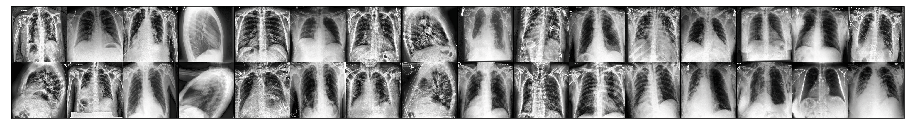

Trainable: 2, Frozen: 362


Score improved: 0.78088 > 0.00000
Epoch [0] train_loss: 0.4410, train_auc: 0.7731, valid_loss: 0.4683, valid_auc: 0.7809


Score improved: 0.78688 > 0.78088
Epoch [1] train_loss: 0.4294, train_auc: 0.7851, valid_loss: 0.4646, valid_auc: 0.7869


Score improved: 0.78902 > 0.78688
Epoch [2] train_loss: 0.4283, train_auc: 0.7883, valid_loss: 0.4639, valid_auc: 0.7890


Score improved: 0.79013 > 0.78902
Epoch [3] train_loss: 0.4277, train_auc: 0.7899, valid_loss: 0.4639, valid_auc: 0.7901


Score improved: 0.79089 > 0.79013
Epoch [4] train_loss: 0.4274, train_auc: 0.7909, valid_loss: 0.4641, valid_auc: 0.7909

CPU times: user 10min 11s, sys: 2min 34s, total: 12min 45s
Wall time: 12min 27s


In [74]:
%%time
train_loader, valid_loader = get_dloaders(32, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-2)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)

#### batch 32, lr=1e-4

==================== Augmentations ====================
Resize(always_apply=True, p=1, height=256, width=256, interpolation=1)
CenterCrop(always_apply=False, p=1.0, height=244, width=244)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


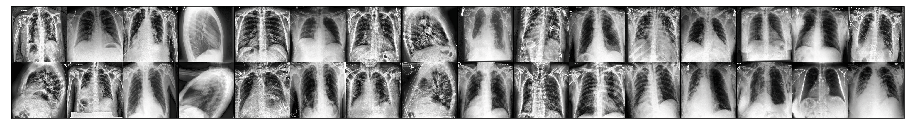

Trainable: 2, Frozen: 362


Score improved: 0.75912 > 0.00000
Epoch [0] train_loss: 0.4206, train_auc: 0.7633, valid_loss: 0.4356, valid_auc: 0.7591


Score improved: 0.77692 > 0.75912
Epoch [1] train_loss: 0.3991, train_auc: 0.7889, valid_loss: 0.4241, valid_auc: 0.7769


Score improved: 0.78701 > 0.77692
Epoch [2] train_loss: 0.3933, train_auc: 0.7972, valid_loss: 0.4179, valid_auc: 0.7870


Score improved: 0.79336 > 0.78701
Epoch [3] train_loss: 0.3895, train_auc: 0.8025, valid_loss: 0.4139, valid_auc: 0.7934


Score improved: 0.79750 > 0.79336
Epoch [4] train_loss: 0.3868, train_auc: 0.8063, valid_loss: 0.4112, valid_auc: 0.7975

CPU times: user 10min 12s, sys: 2min 34s, total: 12min 46s
Wall time: 12min 28s


In [75]:
%%time
train_loader, valid_loader = get_dloaders(32, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-4)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)

#### batch 32, lr=3e-4

==================== Augmentations ====================
Resize(always_apply=True, p=1, height=256, width=256, interpolation=1)
CenterCrop(always_apply=False, p=1.0, height=244, width=244)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


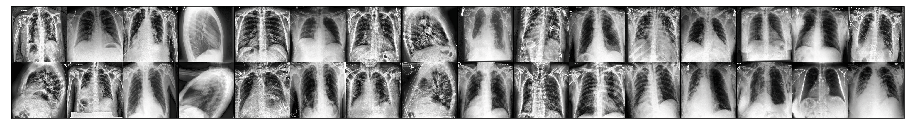

Trainable: 2, Frozen: 362


Score improved: 0.77725 > 0.00000
Epoch [0] train_loss: 0.4061, train_auc: 0.7807, valid_loss: 0.4229, valid_auc: 0.7773


Score improved: 0.79292 > 0.77725
Epoch [1] train_loss: 0.3893, train_auc: 0.8030, valid_loss: 0.4135, valid_auc: 0.7929


Score improved: 0.79999 > 0.79292
Epoch [2] train_loss: 0.3840, train_auc: 0.8105, valid_loss: 0.4094, valid_auc: 0.8000


Score improved: 0.80393 > 0.79999
Epoch [3] train_loss: 0.3806, train_auc: 0.8150, valid_loss: 0.4072, valid_auc: 0.8039


Score improved: 0.80597 > 0.80393
Epoch [4] train_loss: 0.3782, train_auc: 0.8182, valid_loss: 0.4059, valid_auc: 0.8060

CPU times: user 10min 12s, sys: 2min 34s, total: 12min 46s
Wall time: 12min 28s


In [76]:
%%time
train_loader, valid_loader = get_dloaders(32, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=3e-4)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)

#### batch 256, lr=1e-2

In [77]:
%%time
train_loader, valid_loader = get_dloaders(256, 2**14, seed=404)
#show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-2)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)

Trainable: 2, Frozen: 362


Score improved: 0.81892 > 0.00000
Epoch [0] train_loss: 0.4662, train_auc: 0.7715, valid_loss: 0.4009, valid_auc: 0.8189


Epoch [1] train_loss: 0.3854, train_auc: 0.8096, valid_loss: 0.4076, valid_auc: 0.8055


Score improved: 0.82223 > 0.81892
Epoch [2] train_loss: 0.3805, train_auc: 0.8161, valid_loss: 0.3967, valid_auc: 0.8222


Epoch [3] train_loss: 0.3790, train_auc: 0.8184, valid_loss: 0.4027, valid_auc: 0.8171


Epoch [4] train_loss: 0.3781, train_auc: 0.8199, valid_loss: 0.4102, valid_auc: 0.8091

CPU times: user 8min 28s, sys: 2min 38s, total: 11min 6s
Wall time: 11min 17s


#### batch 256, lr=1e-4

In [78]:
%%time
train_loader, valid_loader = get_dloaders(256, 2**14, seed=404)
#show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-4)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)

Trainable: 2, Frozen: 362


Score improved: 0.71149 > 0.00000
Epoch [0] train_loss: 0.4998, train_auc: 0.6823, valid_loss: 0.4649, valid_auc: 0.7115


Score improved: 0.75188 > 0.71149
Epoch [1] train_loss: 0.4170, train_auc: 0.7621, valid_loss: 0.4476, valid_auc: 0.7519


Score improved: 0.76370 > 0.75188
Epoch [2] train_loss: 0.4099, train_auc: 0.7731, valid_loss: 0.4399, valid_auc: 0.7637


Score improved: 0.77024 > 0.76370
Epoch [3] train_loss: 0.4062, train_auc: 0.7783, valid_loss: 0.4350, valid_auc: 0.7702


Score improved: 0.77500 > 0.77024
Epoch [4] train_loss: 0.4035, train_auc: 0.7819, valid_loss: 0.4314, valid_auc: 0.7750

CPU times: user 8min 27s, sys: 2min 39s, total: 11min 7s
Wall time: 11min 18s


#### batch 256, lr=3e-4

In [79]:
%%time
train_loader, valid_loader = get_dloaders(256, 2**14, seed=404)
#show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=3e-4)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)

Trainable: 2, Frozen: 362


Score improved: 0.76511 > 0.00000
Epoch [0] train_loss: 0.4428, train_auc: 0.7363, valid_loss: 0.4397, valid_auc: 0.7651


Score improved: 0.77697 > 0.76511
Epoch [1] train_loss: 0.4044, train_auc: 0.7809, valid_loss: 0.4301, valid_auc: 0.7770


Score improved: 0.78639 > 0.77697
Epoch [2] train_loss: 0.3986, train_auc: 0.7885, valid_loss: 0.4239, valid_auc: 0.7864


Score improved: 0.79308 > 0.78639
Epoch [3] train_loss: 0.3946, train_auc: 0.7942, valid_loss: 0.4196, valid_auc: 0.7931


Score improved: 0.79797 > 0.79308
Epoch [4] train_loss: 0.3916, train_auc: 0.7986, valid_loss: 0.4164, valid_auc: 0.7980

CPU times: user 8min 28s, sys: 2min 39s, total: 11min 8s
Wall time: 11min 19s


### Batch Size

#### batch 16

==================== Augmentations ====================
Resize(always_apply=True, p=1, height=256, width=256, interpolation=1)
CenterCrop(always_apply=False, p=1.0, height=244, width=244)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


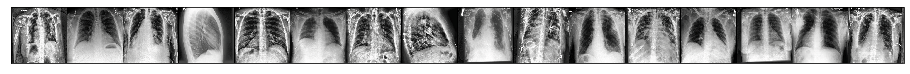

Trainable: 2, Frozen: 362


Score improved: 0.79919 > 0.00000
Epoch [0] train_loss: 0.3998, train_auc: 0.7913, valid_loss: 0.4154, valid_auc: 0.7992


Score improved: 0.80428 > 0.79919
Epoch [1] train_loss: 0.3867, train_auc: 0.8089, valid_loss: 0.4128, valid_auc: 0.8043


Score improved: 0.80480 > 0.80428
Epoch [2] train_loss: 0.3826, train_auc: 0.8142, valid_loss: 0.4125, valid_auc: 0.8048


Epoch [3] train_loss: 0.3804, train_auc: 0.8172, valid_loss: 0.4127, valid_auc: 0.8040


Epoch [4] train_loss: 0.3789, train_auc: 0.8191, valid_loss: 0.4132, valid_auc: 0.8035



In [36]:
train_loader, valid_loader = get_dloaders(16, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)

#### batch 32

==================== Augmentations ====================
Resize(always_apply=True, p=1, height=256, width=256, interpolation=1)
CenterCrop(always_apply=False, p=1.0, height=244, width=244)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


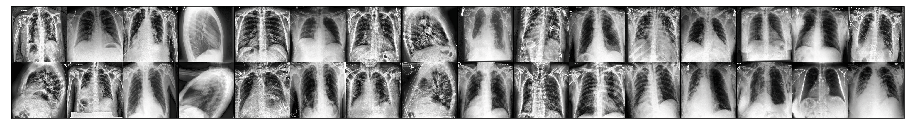

Trainable: 2, Frozen: 362


Score improved: 0.81513 > 0.00000
Epoch [0] train_loss: 0.3992, train_auc: 0.7915, valid_loss: 0.3989, valid_auc: 0.8151


Score improved: 0.81803 > 0.81513
Epoch [1] train_loss: 0.3844, train_auc: 0.8109, valid_loss: 0.3958, valid_auc: 0.8180


Score improved: 0.81821 > 0.81803
Epoch [2] train_loss: 0.3799, train_auc: 0.8168, valid_loss: 0.3953, valid_auc: 0.8182


Epoch [3] train_loss: 0.3773, train_auc: 0.8202, valid_loss: 0.3955, valid_auc: 0.8181


Epoch [4] train_loss: 0.3756, train_auc: 0.8224, valid_loss: 0.3959, valid_auc: 0.8173



In [37]:
train_loader, valid_loader = get_dloaders(32, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)

#### batch 64

==================== Augmentations ====================
Resize(always_apply=True, p=1, height=256, width=256, interpolation=1)
CenterCrop(always_apply=False, p=1.0, height=244, width=244)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


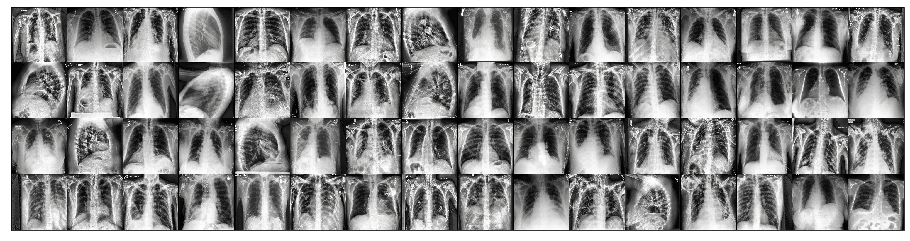

Trainable: 2, Frozen: 362


Score improved: 0.78464 > 0.00000
Epoch [0] train_loss: 0.4027, train_auc: 0.7866, valid_loss: 0.4215, valid_auc: 0.7846


Score improved: 0.79811 > 0.78464
Epoch [1] train_loss: 0.3853, train_auc: 0.8088, valid_loss: 0.4141, valid_auc: 0.7981


Score improved: 0.80255 > 0.79811
Epoch [2] train_loss: 0.3802, train_auc: 0.8157, valid_loss: 0.4117, valid_auc: 0.8026


Score improved: 0.80422 > 0.80255
Epoch [3] train_loss: 0.3772, train_auc: 0.8196, valid_loss: 0.4106, valid_auc: 0.8042


Score improved: 0.80513 > 0.80422
Epoch [4] train_loss: 0.3751, train_auc: 0.8223, valid_loss: 0.4102, valid_auc: 0.8051



In [38]:
train_loader, valid_loader = get_dloaders(64, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)

#### batch 128

==================== Augmentations ====================
Resize(always_apply=True, p=1, height=256, width=256, interpolation=1)
CenterCrop(always_apply=False, p=1.0, height=244, width=244)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


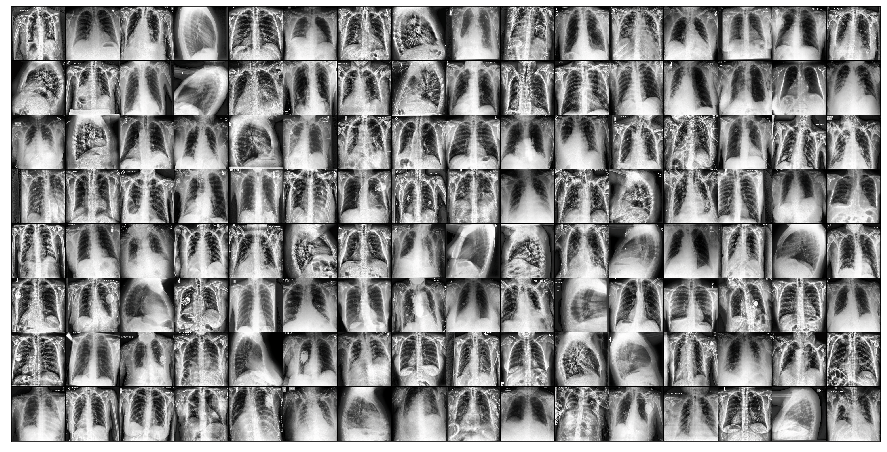

Trainable: 2, Frozen: 362


Score improved: 0.79042 > 0.00000
Epoch [0] train_loss: 0.4099, train_auc: 0.7783, valid_loss: 0.4227, valid_auc: 0.7904


Score improved: 0.80474 > 0.79042
Epoch [1] train_loss: 0.3884, train_auc: 0.8039, valid_loss: 0.4135, valid_auc: 0.8047


Score improved: 0.80926 > 0.80474
Epoch [2] train_loss: 0.3827, train_auc: 0.8119, valid_loss: 0.4103, valid_auc: 0.8093


Score improved: 0.81147 > 0.80926
Epoch [3] train_loss: 0.3793, train_auc: 0.8166, valid_loss: 0.4089, valid_auc: 0.8115


Score improved: 0.81265 > 0.81147
Epoch [4] train_loss: 0.3768, train_auc: 0.8199, valid_loss: 0.4081, valid_auc: 0.8127



In [39]:
train_loader, valid_loader = get_dloaders(128, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)

#### batch 256

==================== Augmentations ====================
Resize(always_apply=True, p=1, height=256, width=256, interpolation=1)
CenterCrop(always_apply=False, p=1.0, height=244, width=244)
CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
HorizontalFlip(always_apply=False, p=0.5)
Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)
-------------------------------------------------------


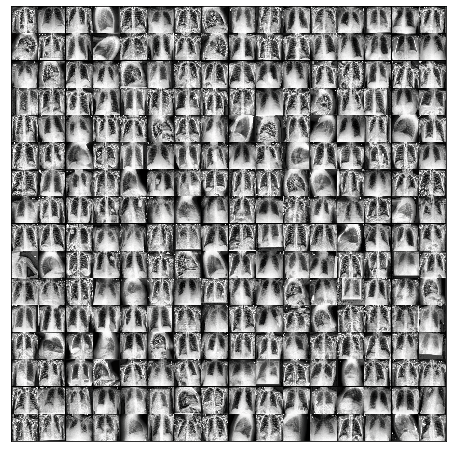

Trainable: 2, Frozen: 362


Score improved: 0.76854 > 0.00000
Epoch [0] train_loss: 0.4228, train_auc: 0.7656, valid_loss: 0.4342, valid_auc: 0.7685


Score improved: 0.79873 > 0.76854
Epoch [1] train_loss: 0.3939, train_auc: 0.7954, valid_loss: 0.4157, valid_auc: 0.7987


Score improved: 0.80922 > 0.79873
Epoch [2] train_loss: 0.3876, train_auc: 0.8045, valid_loss: 0.4081, valid_auc: 0.8092


Score improved: 0.81468 > 0.80922
Epoch [3] train_loss: 0.3837, train_auc: 0.8101, valid_loss: 0.4039, valid_auc: 0.8147


Score improved: 0.81810 > 0.81468
Epoch [4] train_loss: 0.3809, train_auc: 0.8140, valid_loss: 0.4013, valid_auc: 0.8181



In [40]:
train_loader, valid_loader = get_dloaders(256, 2**14, seed=404)
show_batch(train_loader,denorm=True)
criterion = nn.BCEWithLogitsLoss()
model = CheXModel('densenet121')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model,optimizer,criterion)
parstatus = trainer.freeze(['upcast','network.classifier'])
hist = trainer.train(train_loader, valid_loader, 5)